# Parameters

In [1379]:
# Robotermaße
robot_width = 1
robot_length = 6

# Start- und Zielpunkt festlegen
start_point = (3, 8)
goal_point = (12, 8)
start_rotation = 0 # 0° rotation
current_position=(start_point[0], start_point[1], int((start_rotation/90)))

# Define Occupancy Grid

In [1380]:
import numpy as np

def add_obstacle(occupancy_grid, width, length, x, y):
    width_occ_grid = len(occupancy_grid[0])
    height_occ_grid = len(occupancy_grid)

    start_row = y
    end_row = min(height_occ_grid, y + length)
    start_col = x
    end_col = min(width_occ_grid, x + width)

    for row in range(start_row, end_row):
        for col in range(start_col, end_col):
            occupancy_grid[row][col] = False

    return occupancy_grid

def generate_empty_occupancy_grid(size):
    empty_occupancy_grid = np.ones((size, size), dtype=bool)

    return empty_occupancy_grid

In [1381]:
# Obstacles
occupancy_grid = generate_empty_occupancy_grid(18)
occupancy_grid = add_obstacle(
    occupancy_grid=occupancy_grid,
    width=1,
    length=3,
    x=8,
    y=4)
occupancy_grid = add_obstacle(
    occupancy_grid=occupancy_grid,
    width=1,
    length=2,
    x=8,
    y=11)

# Plot Occupancy Grid

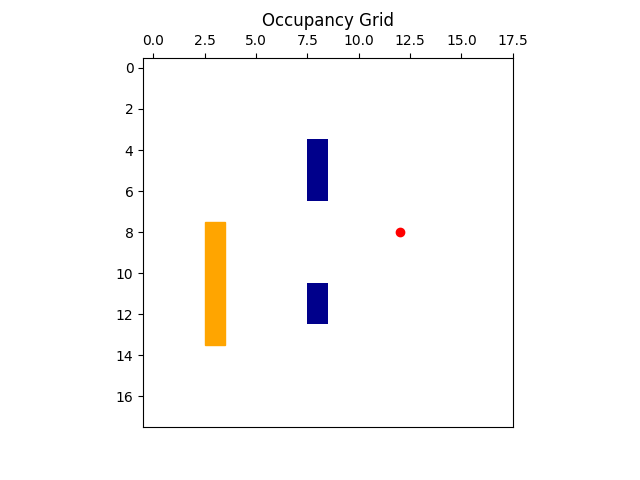

In [1382]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_occupancy_grid(occupancy_grid, goal_point, plot_axis, current_position=None, path=[], robot_width=None, robot_length=None, active=True, plot_title="Occupancy Grid", y_axis_label=None, start_point=None):
    plot_axis.clear()

    if active:
        cmap = ListedColormap(['darkblue', 'white'])        
        start_color = 'green'
        goal_color = 'red'
        path_color = 'blue'
        current_color = 'orange'
    else:
        cmap = 'gray'
        start_color = 'black'
        goal_color = 'dimgray'
        path_color = 'darkgray'
        current_color = 'gray'
        line_color = 'black'

    plot_axis.imshow(occupancy_grid, cmap=cmap, interpolation='nearest', origin='upper')
    if start_point is not None:
        plot_axis.scatter(start_point[0], start_point[1], color=start_color, marker='o', label='Start Point')
    plot_axis.scatter(goal_point[0], goal_point[1], color=goal_color, marker='o', label='Goal Point')
    plot_axis.plot([p[0] for p in path], [p[1] for p in path], color=path_color, label='Chosen Path')

    if current_position is not None:
        current_x, current_y, current_rotation = current_position
        if robot_width is None or robot_length is None:
            # Darstellung des aktuellen Roboters als x
            if not occupancy_grid[current_y, current_x]:
                plot_axis.scatter(current_x, current_y, color=current_color, marker='x', label='Current Position')
            else:
                plot_axis.scatter(current_x, current_y, color=current_color, marker='o', label='Current Position')
                # Darstellung des aktuellen Roboters als Rechteck
        else:
            current_rect = plt.Rectangle(
                (current_x - 0.5, current_y - 0.5),
                robot_width,
                robot_length,
                rotation_point=(current_x, current_y),
                angle=current_rotation * -90,  # Rotation in Grad umrechnen
                color=current_color,
                label='Current Position'
            )
            plot_axis.add_patch(current_rect)

    plot_axis.grid(False)
    plot_axis.set_title(plot_title)

    # Beschriftung der X-Achse oben
    plot_axis.xaxis.tick_top()

    if y_axis_label is not None:
        # Optionale Beschriftung Y-Achse
        plot_axis.text(-0.15, 0.5, y_axis_label, rotation='horizontal', va='center', ha='right', transform=plot_axis.transAxes)


fig = plt.figure()
plot_axis = fig.add_subplot(111)
plot_occupancy_grid(
    occupancy_grid=occupancy_grid, 
    goal_point=goal_point, 
    current_position=current_position, 
    plot_axis=plot_axis, 
    robot_width=robot_width, 
    robot_length=robot_length,
    start_point=start_point)
plt.show()

# Compute Computational Spaces

In [1383]:
def compute_cs_0deg(occupancy_grid, robot_width, robot_length):
    height = len(occupancy_grid)
    width = len(occupancy_grid[0])

    computational_space = np.full((height, width), True)

    for row in range(height):
        for col in range(width):
            if not occupancy_grid[row][col]:
                # Koordinaten im quadratischen Bereich um das Hindernis auf False setzen
                start_row = max(0, row - (robot_length - 1))
                end_row = min(height, row + 1)
                start_col = max(0, col - (robot_width - 1))
                end_col = min(width, col + 1)

                for i in range(start_row, end_row):
                    for j in range(start_col, end_col):
                        computational_space[i][j] = False

    # Alle Zeilen bis height-robot_length auf False setzen
    for row in range(height - robot_length + 1, height):
        for col in range(width):
            computational_space[row][col] = False

    # Alle Spalten bis width-robot_width auf False setzen
    for col in range(width - robot_width + 1, width):
        for row in range(height):
            computational_space[row][col] = False

    return computational_space


def compute_cs_90deg(occupancy_grid, robot_width, robot_length):
    height = len(occupancy_grid)
    width = len(occupancy_grid[0])

    computational_space = np.full((height, width), True)

    for row in range(height):
        for col in range(width):
            if not occupancy_grid[row][col]:
                # Koordinaten im quadratischen Bereich um das Hindernis auf False setzen
                start_row = row
                end_row = min(height, row + robot_width)
                start_col = max(0, col - robot_length + 1)
                end_col = min(width, col + 1)

                for i in range(start_row, end_row):
                    for j in range(start_col, end_col):
                        computational_space[i][j] = False

    # Alle oberen (robot_width-1) Zeilen auf False setzen
    for row in range(robot_width - 1):
        for col in range(width):
            computational_space[row][col] = False

    # Alle rechten (robot_length-1) Spalten auf False setzen
    for col in range((width - robot_length + 1), width):
        for row in range(height):
            computational_space[row][col] = False

    return computational_space


def compute_cs_180deg(occupancy_grid, robot_width, robot_length):
    width = len(occupancy_grid[0])
    height = len(occupancy_grid)

    computational_space = np.full((height, width), True)

    for row in range(height):
        for col in range(width):
            if not occupancy_grid[row][col]:
                # Koordinaten im quadratischen Bereich um das Hindernis auf False setzen
                start_row = row
                end_row = min(height, row + robot_length)
                start_col = col
                end_col = min(width, col + robot_width)

                for i in range(start_row, end_row):
                    for j in range(start_col, end_col):
                        computational_space[i][j] = False

    # Alle oberen (robot_length-1) Zeilen auf False setzen
    for row in range(robot_length - 1):
        for col in range(width):
            computational_space[row][col] = False

    # Alle linken (robot_width-1) Spalten auf False setzen
    for col in range(robot_width - 1):
        for row in range(height):
            computational_space[row][col] = False

    return computational_space



def compute_cs_270deg(occupancy_grid, robot_width, robot_length):
    height = len(occupancy_grid)
    width = len(occupancy_grid[0])

    computational_space = np.full((height, width), True)

    for row in range(height):
        for col in range(width):
            if not occupancy_grid[row][col]:
                # Koordinaten im quadratischen Bereich um das Hindernis auf False setzen
                start_row = max(0, row - robot_width + 1)
                end_row = min(height, row + 1)
                start_col = col
                end_col = min(width, col + robot_length)

                for i in range(start_row, end_row):
                    for j in range(start_col, end_col):
                        computational_space[i][j] = False

    # Alle unteren (robot_width-1) Zeilen auf False setzen
    for row in range((height - robot_width + 1), height):
        for col in range(width):
            computational_space[row][col] = False

    # Alle linken (robot_length-1) Spalten auf False setzen
    for col in range(robot_length - 1):
        for row in range(height):
            computational_space[row][col] = False

    return computational_space

In [1384]:
computational_space_list = []
computational_space_list.append(compute_cs_0deg(
                    occupancy_grid=occupancy_grid,
                    robot_width=robot_width,
                    robot_length=robot_length))
computational_space_list.append(compute_cs_90deg(
                    occupancy_grid=occupancy_grid,
                    robot_width=robot_width,
                    robot_length=robot_length))
computational_space_list.append(compute_cs_180deg(
                    occupancy_grid=occupancy_grid,
                    robot_width=robot_width,
                    robot_length=robot_length))
computational_space_list.append(compute_cs_270deg(
                    occupancy_grid=occupancy_grid,
                    robot_width=robot_width,
                    robot_length=robot_length))
computational_space = np.array(computational_space_list)

# Plot Computational Spaces

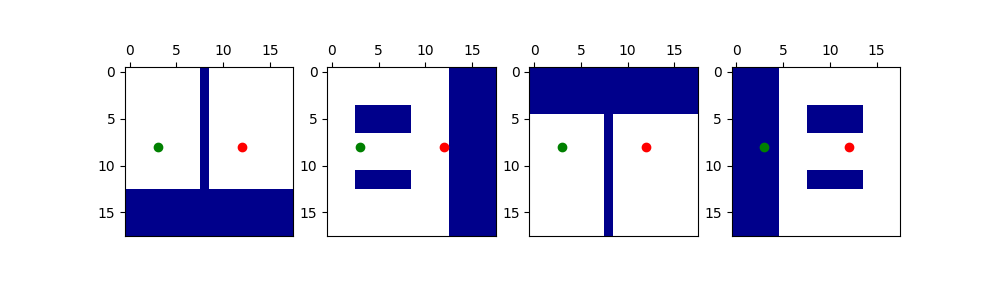

In [1385]:
%matplotlib widget
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 3))
for rotation in range(4):      
    ax_occupancy_grid = fig.add_subplot(1, 4, rotation+1)
    plot_occupancy_grid(
        occupancy_grid=computational_space[rotation], 
        goal_point=goal_point, 
        plot_axis=ax_occupancy_grid, 
        robot_width=robot_width, 
        robot_length=robot_length,
        start_point=start_point,
        plot_title="")
    
plt.show()


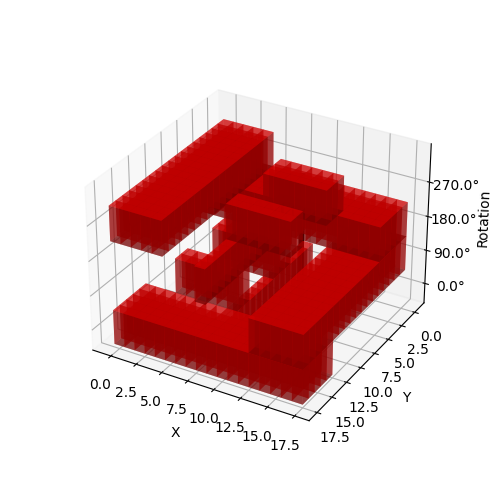

In [1386]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_computational_space_3d(computational_space, goal_point, ax):
    rotation, size_y, size_x = computational_space.shape

    for r in range(rotation):
        for y in range(size_y):
            for x in range(size_x):
                if not computational_space[r, y, x]:
                    # Zentriere den transparenten Würfel über der Koordinate
                    ax.bar3d(x - 0.5, y - 0.5, r - 0.5, 1, 1, 1, color='red', alpha=0.5)

    # Füge eine vertikale schwarze Linie für den Zielpunkt hinzu
    ax.plot([goal_point[0], goal_point[0]], [goal_point[1], goal_point[1]], [0, rotation], color='black', linestyle='-', linewidth=4)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Rotation')

    # Füge Z-Ticks für die Rotation hinzu
    ax.set_zticks(np.arange(rotation))
    ax.set_zticklabels([f'{angle}°' for angle in np.arange(0, 360, 360/rotation)])

    # Invertiere die Y-Achse
    ax.invert_yaxis()

fig = plt.figure(figsize=(5, 5))
plot_axis = fig.add_subplot(111, projection='3d')
plot_computational_space_3d(computational_space, goal_point,plot_axis)
plt.show()

# Compute Potentials and Force Vectors

In [1387]:
import numpy as np

def compute_potentials_3d(cs_space, goal, attraction_weight=4, repulsion_weight=1):
    size_rotation, size_y, size_x = cs_space.shape
    attraction_potential = np.zeros((size_rotation, size_y, size_x))
    repulsion_potential = np.zeros((size_rotation, size_y, size_x))

    for rotation in range(size_rotation):
        for y in range(size_y):
            for x in range(size_x):
                # Abstand zum Ziel
                distance_to_goal = np.sqrt((y - goal[1])**2 + (x - goal[0])**2)

                # Anziehendes Potential zum Ziel (Quadratische Funktion)
                attraction_potential[rotation, y, x] = distance_to_goal**2


                repulsive_potentials_to_all_objects = []
                # Abstand zu Hindernissen in der aktuellen Rotationsebene
                distances_to_obstacles = np.sqrt((y - np.where(cs_space[rotation] == False)[0])**2 +
                                                 (x - np.where(cs_space[rotation] == False)[1])**2)
                for distance_to_obstacle in distances_to_obstacles:
                    # Abstoßendes Potential von Hindernissen in der aktuellen Rotationsebene (Quadratische Funktion)
                    repulsive_potentials_to_all_objects.append((1 / (repulsion_weight + distance_to_obstacle)) if distance_to_obstacle != 0 else 1) # or repulsion_weight ???

                # Abstand zu Hindernissen in den benachbarten Rotationsebenen
                adjacent_rotations = [(rotation + 1) % size_rotation, (rotation - 1) % size_rotation]
                distances_to_obstacles_adjacent_grids = [(np.sqrt(
                                                        (y - np.where(cs_space[adj_rotation] == False)[0])**2 +
                                                        (x - np.where(cs_space[adj_rotation] == False)[1])**2)+
                                                        (rotation - adj_rotation)**2)
                                                    for adj_rotation in adjacent_rotations]
                
                for distances_to_obstacles_adjacent_grid in distances_to_obstacles_adjacent_grids:
                    for distance_to_obstacles_adjacent in distances_to_obstacles_adjacent_grid:
                        repulsive_potentials_to_all_objects.append((1 / (repulsion_weight + distance_to_obstacles_adjacent)) if distance_to_obstacles_adjacent != 0 else 1) # or repulsion_weight ???)
                                
                repulsion_potential[rotation, y, x] = np.max(repulsive_potentials_to_all_objects)
                

    normalized_attraction_potential = (attraction_potential / np.max(attraction_potential)) * attraction_weight
    #normalized_repulsion_potential = repulsion_potential #/ np.max(repulsion_potential)


    return normalized_attraction_potential, repulsion_potential


def compute_force_field_3d(total_potential):
    # Berechne die Gradienten des Potentials
    grad_rotation, grad_y, grad_x = np.gradient(total_potential)

    # Die negierten Gradienten repräsentieren die Kräfte
    force_field_x = -grad_x
    force_field_y = -grad_y
    force_field_rotation = -grad_rotation

    return force_field_x, force_field_y, force_field_rotation

attraction_potential, repulsion_potential = compute_potentials_3d(computational_space, goal_point)
total_potential = attraction_potential + repulsion_potential
force_field_x, force_field_y, force_field_rotation = compute_force_field_3d(total_potential)

np.max(attraction_potential)

4.0

# Plot Potentials

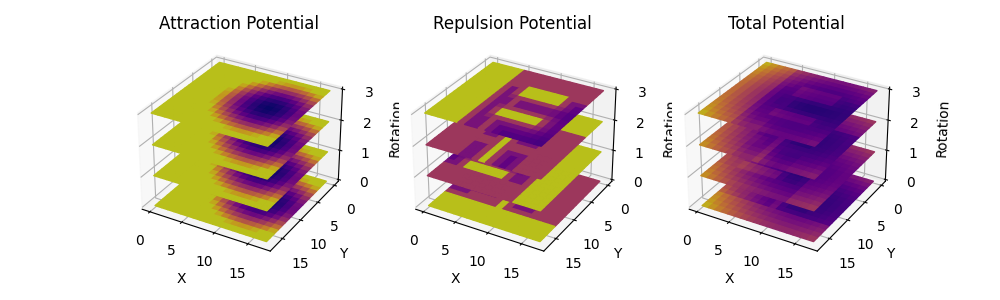

'\noccupancy_grid = add_obstacle(\n    occupancy_grid=occupancy_grid,\n    width=3,\n    length=1,\n    x=2,\n    y=3)\noccupancy_grid = add_obstacle(\n    occupancy_grid=occupancy_grid,\n    width=1,\n    length=3,\n    x=7,\n    y=7)\n'

In [1388]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_potential(potential, title, ax):
    rotation, size_y, size_x = potential.shape

    # Erzeuge ein Gitter im 3D-Raum
    x = np.arange(size_x)
    y = np.arange(size_y)
    X, Y = np.meshgrid(x, y)

    # Plotte die 3D-imshow für jede Rotationsebene
    for r in range(rotation):
        Z = np.full_like(X, r)  # Z-Koordinate auf Höhe der Rotationsebene
        ax.plot_surface(X, Y, Z, facecolors=plt.cm.plasma(potential[r, :, :]), rstride=1, cstride=1, alpha=1, antialiased=True)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Rotation')
    ax.set_title(title)
    ax.invert_yaxis()

fig = plt.figure(figsize=(10, 3))
visualize_3d_potential(attraction_potential, 'Attraction Potential', fig.add_subplot(131, projection='3d'))
visualize_3d_potential(repulsion_potential, 'Repulsion Potential', fig.add_subplot(132, projection='3d'))
visualize_3d_potential(total_potential/np.max(total_potential), 'Total Potential', fig.add_subplot(133, projection='3d'))
plt.show()

'''
occupancy_grid = add_obstacle(
    occupancy_grid=occupancy_grid,
    width=3,
    length=1,
    x=2,
    y=3)
occupancy_grid = add_obstacle(
    occupancy_grid=occupancy_grid,
    width=1,
    length=3,
    x=7,
    y=7)
'''

# Plot Force Vectors

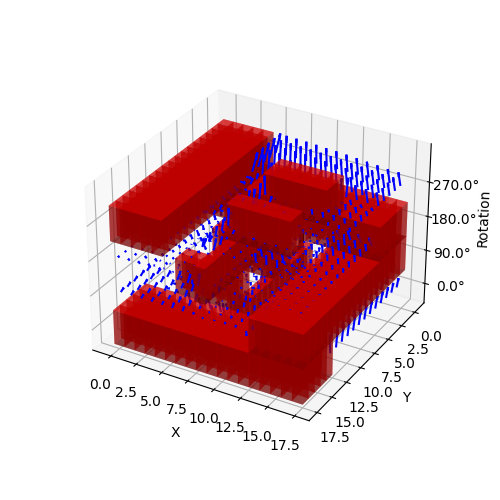

In [1389]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def visualize_space_and_forces(computational_space, force_field_x, force_field_y, force_field_rotation, goal_point, plot_axis):
    rotation, size_y, size_x = computational_space.shape

    # Berechne die maximale Pfeillänge
    max_force = np.max(force_field_x + force_field_y + force_field_rotation)

    for r in range(rotation):
        for y in range(size_y):
            for x in range(size_x):
                if not computational_space[r, y, x]:
                    # Zentriere den transparenten Würfel über der Koordinate
                    plot_axis.bar3d(x - 0.5, y - 0.5, r - 0.5, 1, 1, 1, color='red', alpha=0.5)

                    # Zentriere den Kraftpfeil über der Koordinate
                else:

                    # Berechne die Summe der Force-Fields an dieser Position
                    length = (force_field_x[r, y, x] + force_field_y[r, y, x] + force_field_rotation[r, y, x]) / max_force
                    plot_axis.quiver(x, y, r, force_field_x[r, y, x], force_field_y[r, y, x], force_field_rotation[r, y, x],
                            color='blue', length=length, normalize=True)

    # Füge eine vertikale schwarze Linie für den Zielpunkt hinzu
    plot_axis.plot([goal_point[0], goal_point[0]], [goal_point[1], goal_point[1]], [0, rotation], color='black', linestyle='-', linewidth=4)

    plot_axis.set_xlabel('X')
    plot_axis.set_ylabel('Y')
    plot_axis.set_zlabel('Rotation')

    # Füge Z-Ticks für die Rotation hinzu
    plot_axis.set_zticks(np.arange(rotation))
    plot_axis.set_zticklabels([f'{angle}°' for angle in np.arange(0, 360, 360/rotation)])

    # Invertiere die Y-Achse
    plot_axis.invert_yaxis()

fig = plt.figure(figsize=(5, 5))
plot_axis = fig.add_subplot(111, projection='3d')
visualize_space_and_forces(computational_space, force_field_x, force_field_y, force_field_rotation, goal_point, plot_axis)
plt.show()

# Gradient Descent Step

In [1392]:
def gradient_descent(current_position, force_field_x, force_field_y, force_field_rotation):
    x, y, rotation = current_position

    force_x = force_field_x[rotation, y, x]
    force_y = force_field_y[rotation, y, x]
    force_rotation = force_field_rotation[rotation, y, x]

    print("Force_x: " + str(abs(force_x)))
    print("Force_y: " + str(abs(force_y)))
    print("Force_rotation: " + str(abs(force_rotation)))

    if abs(force_x) > abs(force_y) and abs(force_x) > abs(force_rotation):
        new_x = x + 1 if force_x > 0 else x - 1
        return (new_x, y, rotation)
    elif abs(force_y) > abs(force_x) and abs(force_y) > abs(force_rotation):
        new_y = y + 1 if force_y > 0 else y - 1
        return (x, new_y, rotation)
    else:
        new_rotation = (rotation + 1) % len(force_field_rotation)
        if force_rotation < 0:
            new_rotation = (rotation - 1) % len(force_field_rotation)
        return (x, y, new_rotation)

# Visualize

(3, 8, 0)


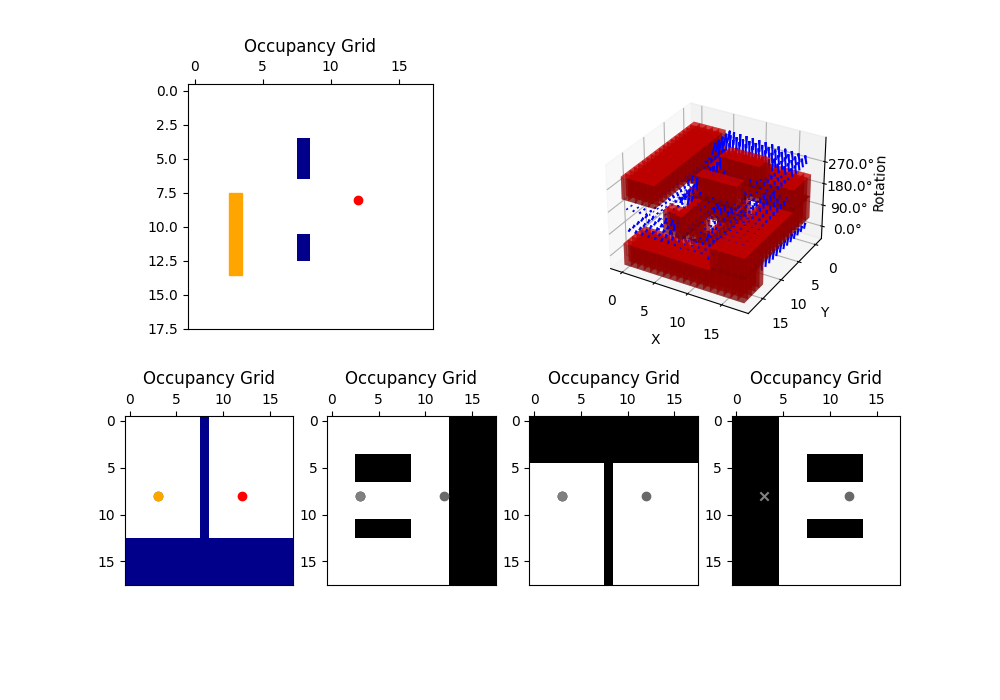

Force_x: 0.31303398874989485
Force_y: 0.04166666666666663
Force_rotation: 0.08333333333333326
(4, 8, 0)
Force_x: 0.2844444444444445
Force_y: 0.04166666666666663
Force_rotation: 0.08333333333333326
(5, 8, 0)
Force_x: 0.2072222222222222
Force_y: 0.04166666666666663
Force_rotation: 0.08333333333333348
(6, 8, 0)
Force_x: 0.08833333333333326
Force_y: 0.0
Force_rotation: 0.0
(7, 8, 0)
Force_x: 0.15555555555555556
Force_y: 0.0
Force_rotation: 0.16666666666666674
(7, 8, 1)
Force_x: 0.09444444444444444
Force_y: 0.08333333333333331
Force_rotation: 0.0
(8, 8, 1)
Force_x: 0.1422222222222222
Force_y: 0.0
Force_rotation: 0.0
(9, 8, 1)
Force_x: 0.22606472918479598
Force_y: 0.04044011451988094
Force_rotation: 0.0
(10, 8, 1)
Force_x: 0.0711111111111111
Force_y: 0.023906559705602987
Force_rotation: 0.0
(11, 8, 1)
Force_x: 0.08384250696257373
Force_y: 0.0
Force_rotation: 0.0
(10, 8, 1)
Force_x: 0.0711111111111111
Force_y: 0.023906559705602987
Force_rotation: 0.0
(11, 8, 1)


In [1393]:
fig = plt.figure(figsize=(10, 7))

ax_occupancy_grid = fig.add_subplot(2, 4, (1,2))
ax_cs_3D_force_vetors = fig.add_subplot(2, 4, (3,4), projection='3d')

ax_cs_2D = [fig.add_subplot(2, 4, 5), fig.add_subplot(2, 4, 6), fig.add_subplot(2, 4, 7), fig.add_subplot(2, 4, 8)]

def on_key(event):
    global current_position, path
    current_position = gradient_descent(
                        current_position=current_position,
                        force_field_x=force_field_x,
                        force_field_y=force_field_y,
                        force_field_rotation=force_field_rotation)  
    print(current_position)
    visualize_space_and_forces(computational_space, force_field_x, force_field_y, force_field_rotation, goal_point, ax_cs_3D_force_vetors)
    plot_occupancy_grid(
        occupancy_grid=occupancy_grid,
        start_point=start_point,
        goal_point=goal_point,
        current_position=current_position,
        robot_width=robot_width,
        robot_length=robot_length,
        plot_axis=ax_occupancy_grid
    )
    for rotation in range(4):
        
        plot_occupancy_grid(
            occupancy_grid=computational_space[rotation],
            start_point=start_point,
            goal_point=goal_point,
            current_position=current_position,
            plot_axis=ax_cs_2D[rotation],
            active = current_position[2] == rotation
    )

    # path.append(tuple(current_position))
    plt.draw()
    

visualize_space_and_forces(computational_space, force_field_x, force_field_y, force_field_rotation, goal_point, ax_cs_3D_force_vetors)
plot_occupancy_grid(
    occupancy_grid=occupancy_grid,
    start_point=start_point,
    goal_point=goal_point,
    current_position=current_position,
    robot_width=robot_width,
    robot_length=robot_length,
    plot_axis=ax_occupancy_grid
)
for rotation in range(4):
    plot_occupancy_grid(
    occupancy_grid=computational_space[rotation],
    start_point=start_point,
    goal_point=goal_point,
    current_position=current_position,
    plot_axis=ax_cs_2D[rotation],
    active = current_position[2] == rotation
)
print(current_position)


# Verbinde die Tasten mit der Funktion on_key
fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()